In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
def nos(c,in1):
        in2=np.where(c[in1[0]]==0)
        in3=np.where(c[in1[0]]>0)
        return len(in2[0]),len(in3[0])
    
def pcal(f,c):
        mf=np.mean(f)
        in1=np.where(f<=mf)
        in2=np.where(f>mf)
        n00,n01=nos(c,in1)
        n10,n11=nos(c,in2)
        if (n00==0 or n01==0):
            p00=0.5
            p01=0.5
        else:
            p00=n00/(n00+n01)
            p01=n01/(n00+n01)
        if(n10==0 or n11==0):
            p10=0.5
            p11=0.5
        else:
            p10=n10/(n10+n11)
            p11=n11/(n10+n11)
        return p00,p01,p10,p11,in1,in2
    
def giniscal(f,c):
        p00,p01,p10,p11,in1,in2=pcal(f,c)
        gl=1-p00*p00-p01*p01;
        gr=1-p10*p10-p11*p11;
        fgs=(len(in1[0])/(len(in1[0])+len(in2[0])))*gl+(len(in2[0])/(len(in1[0])+len(in2[0])))*gr
        return fgs,np.mean(f)
def cecal(f,c):
        p00,p01,p10,p11,in1,in2=pcal(f,c)
        ce1=1-max(p00,p01)
        ce2=1-max(p10,p11)
        pce=(len(in1[0])/(len(in1[0])+len(in2[0])))*ce1+(len(in2[0])/(len(in1[0])+len(in2[0])))*ce2
        return pce,np.mean(f)
def entrcal(f,c):
        p00,p01,p10,p11,in1,in2=pcal(f,c)
        pup=(len(in1[0]))/(len(in1[0])+len(in2[0]))
        pdown=(len(in2[0]))/(len(in1[0])+len(in2[0]))
        el=(-1*p00*np.log2(p00))+(-1*p01*np.log2(p01))
        er=(-1*p10*np.log2(p10))+(-1*p11*np.log2(p11))
        ep=(-1*pup*np.log2(pup))+(-1*pdown*np.log2(pdown))
        return ep,np.mean(f)
def chisqcal(f,c):
    mf=np.mean(f)
    in1=np.where(f<=mf)
    in2=np.where(f>mf)
    n00,n01=nos(c,in1)
    n10,n11=nos(c,in2)
    Nyy=((n11+n01)*(n11+n10))/(len(in1[0])+len(in2[0]))
    Nyn=((n10+n00)*(n11+n10))/(len(in1[0])+len(in2[0]))
    Nny=((n11+n01)*(n01+n00))/(len(in1[0])+len(in2[0]))
    Nnn=((n10+n00)*(n01+n00))/(len(in1[0])+len(in2[0]))
    cs=(((Nyy-n11)*(Nyy-n11))/(Nyy+0.000001))+(((Nyn-n10)*(Nyn-n10))/(Nyn+0.000001))+(((Nny-n01)*(Nny-n01))/(Nny+0.000001))+(((Nnn-n00)*(Nnn-n00))/(Nnn+0.000001))
    return cs,np.mean(f)
def igcal(f,c):
    p00,p01,p10,p11,in1,in2=pcal(f,c)
    pup=(len(in1[0]))/(len(in1[0])+len(in2[0]))
    pdown=(len(in2[0]))/(len(in1[0])+len(in2[0]))
    el=(-1*p00*np.log2(p00+0.00001))+(-1*p01*np.log2(p01+0.00001))
    er=(-1*p10*np.log2(p10+0.00001))+(-1*p11*np.log2(p11+0.00001))
    ep=(-1*pup*np.log2(pup+0.00001))+(-1*pdown*np.log2(pdown+0.00001))
    infogain=ep-((len(in1[0])/(len(in1[0])+len(in2[0])))*el+(len(in2[0])/(len(in1[0])+len(in2[0])))*er)
    return infogain,np.mean(f)
def grcal(f,c):
    p00,p01,p10,p11,in1,in2=pcal(f,c)
    pup=(len(in1[0]))/(len(in1[0])+len(in2[0])+0.0001)
    pdown=(len(in2[0]))/(len(in1[0])+len(in2[0])+0.0001)
    el=(-1*p00*np.log2(p00+0.00001))+(-1*p01*np.log2(p01+0.00001))
    er=(-1*p10*np.log2(p10+0.00001))+(-1*p11*np.log2(p11+0.00001))
    ep=(-1*pup*np.log2(pup+0.00001))+(-1*pdown*np.log2(pdown+0.00001))
    infogain=ep-((len(in1[0])/(len(in1[0])+len(in2[0])))*el+(len(in2[0])/(len(in1[0])+len(in2[0])))*er)
    splinfo=-pup*np.log2(pup+0.0001)-pdown*np.log2(pdown+0.0001)
    gr=infogain/(splinfo+0.0001)
    return gr,np.mean(f)

In [3]:
class Node:
    def __init__(self,predicted_class):
        self.predicted_class =predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.cltillnow=[]
        self.left = None
        self.right = None

In [4]:
class modelCART:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X_train, y_ac):
        self.n_classes_ = len(set(y_ac))
        self.n_features_ = X_train.shape[1]
        self.dt = self.buildTree(X_train, y_ac)

    def predict(self, X_test):
        return [self.class_predict(i) for i in X_test]


    def bestFeature(self, X, y,arr):
        nof = y.size
        if nof <= 1:
            return None, None
        gsv=np.zeros(20)
        thr=np.zeros(20)
        for j in range(0,20):
            f,c = zip(*sorted(zip(X[:,j], y)))
            gsv[j],thr[j]=giniscal(np.array(f),np.array(c))
        if len(arr)>0:
            for i in arr:
                    gsv[i]=1
        fgsv=np.argmin(gsv)
        return fgsv,thr[fgsv]

    def buildTree(self, X, y, d=0,arr=[]):
        tot=[np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(tot)
        node = Node(predicted_class=predicted_class)
        if d<self.max_depth:
            idx, thr = self.bestFeature(X, y,arr)
            if idx is not None:
                ind_left = X[:, idx] < thr
                X_left, y_left = X[ind_left], y[ind_left]
                X_right, y_right = X[~ind_left], y[~ind_left]
                node.feature_index = idx
                arr.append(idx)
                node.cltillnow=arr
                node.threshold = thr
                node.left = self.buildTree(X_left, y_left, d + 1,arr)
                node.right = self.buildTree(X_right, y_right, d+ 1,arr)
        return node

    def class_predict(self,X):
        node = self.dt
        while node.left:
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [5]:
class modelID3:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X_train, y_ac):
        self.n_classes_ = len(set(y_ac))
        self.n_features_ = X_train.shape[1]
        self.dt = self.buildTree(X_train, y_ac)

    def predict(self, X_test):
        return [self.class_predict(i) for i in X_test]


    def bestFeature(self, X, y,arr):
        nof = y.size
        if nof <= 1:
            return None, None
        infog=np.zeros(20)
        thr=np.zeros(20)
        for j in range(0,20):
            f,c = zip(*sorted(zip(X[:,j], y)))
            infog[j],thr[j]=igcal(np.array(f),np.array(c))
        if len(arr)>0:
            for i in arr:
                    infog[i]=1
        finfog=np.argmax(infog)
        return finfog,thr[finfog]

    def buildTree(self, X, y, d=0,arr=[]):
        tot=[np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(tot)
        node = Node(predicted_class=predicted_class)
        if d<self.max_depth:
            idx, thr = self.bestFeature(X, y,arr)
            if idx is not None:
                ind_left = X[:, idx] < thr
                X_left, y_left = X[ind_left], y[ind_left]
                X_right, y_right = X[~ind_left], y[~ind_left]
                node.feature_index = idx
                arr.append(idx)
                node.cltillnow=arr
                node.threshold = thr
                node.left = self.buildTree(X_left, y_left, d + 1,arr)
                node.right = self.buildTree(X_right, y_right, d+ 1,arr)
        return node

    def class_predict(self,X):
        node = self.dt
        while node.left:
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [6]:
class modelC45:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X_train, y_ac):
        self.n_classes_ = len(set(y_ac))
        self.n_features_ = X_train.shape[1]
        self.dt = self.buildTree(X_train, y_ac)

    def predict(self, X_test):
        return [self.class_predict(i) for i in X_test]


    def bestFeature(self, X, y,arr):
        nof = y.size
        if nof <= 1:
            return None, None
        gr=np.zeros(20)
        thr=np.zeros(20)
        for j in range(0,20):
            f,c = zip(*sorted(zip(X[:,j], y)))
            gr[j],thr[j]=grcal(np.array(f),np.array(c))
        if len(arr)>0:
            for i in arr:
                    gr[i]=1
        fgr=np.argmax(gr)
        return fgr,thr[fgr]

    def buildTree(self, X, y, d=0,arr=[]):
        tot=[np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(tot)
        node = Node(predicted_class=predicted_class)
        if d<self.max_depth:
            idx, thr = self.bestFeature(X, y,arr)
            if idx is not None:
                ind_left = X[:, idx] < thr
                X_left, y_left = X[ind_left], y[ind_left]
                X_right, y_right = X[~ind_left], y[~ind_left]
                node.feature_index = idx
                arr.append(idx)
                node.cltillnow=arr
                node.threshold = thr
                node.left = self.buildTree(X_left, y_left, d + 1,arr)
                node.right = self.buildTree(X_right, y_right, d+ 1,arr)
        return node

    def class_predict(self,X):
        node = self.dt
        while node.left:
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [7]:
class model_mce:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X_train, y_ac):
        self.n_classes_ = len(set(y_ac))
        self.n_features_ = X_train.shape[1]
        self.dt = self.buildTree(X_train, y_ac)

    def predict(self, X_test):
        return [self.class_predict(i) for i in X_test]


    def bestFeature(self, X, y,arr):
        nof = y.size
        if nof <= 1:
            return None, None
        ce=np.zeros(20)
        thr=np.zeros(20)
        for j in range(0,20):
            f,c = zip(*sorted(zip(X[:,j], y)))
            ce[j],thr[j]=cecal(np.array(f),np.array(c))
        if len(arr)>0:
            for i in arr:
                    ce[i]=1
        fce=np.argmin(ce)
        return fce,thr[fce]

    def buildTree(self, X, y, d=0,arr=[]):
        tot=[np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(tot)
        node = Node(predicted_class=predicted_class)
        if d<self.max_depth:
            idx, thr = self.bestFeature(X, y,arr)
            if idx is not None:
                ind_left = X[:, idx] < thr
                X_left, y_left = X[ind_left], y[ind_left]
                X_right, y_right = X[~ind_left], y[~ind_left]
                node.feature_index = idx
                arr.append(idx)
                node.cltillnow=arr
                node.threshold = thr
                node.left = self.buildTree(X_left, y_left, d + 1,arr)
                node.right = self.buildTree(X_right, y_right, d+ 1,arr)
        return node

    def class_predict(self,X):
        node = self.dt
        while node.left:
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [8]:
class modelCHAID:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X_train, y_ac):
        self.n_classes_ = len(set(y_ac))
        self.n_features_ = X_train.shape[1]
        self.dt = self.buildTree(X_train, y_ac)

    def predict(self, X_test):
        return [self.class_predict(i) for i in X_test]


    def bestFeature(self, X, y,arr):
        nof = y.size
        if nof <= 1:
            return None, None
        chv=np.zeros(20)
        thr=np.zeros(20)
        for j in range(0,20):
            f,c = zip(*sorted(zip(X[:,j], y)))
            chv[j],thr[j]=chisqcal(np.array(f),np.array(c))
        if len(arr)>0:
            for i in arr:
                    chv[i]=1
        fchv=np.argmax(chv)
        return fchv,thr[fchv]

    def buildTree(self, X, y, d=0,arr=[]):
        tot=[np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(tot)
        node = Node(predicted_class=predicted_class)
        if d<self.max_depth:
            idx, thr = self.bestFeature(X, y,arr)
            if idx is not None:
                ind_left = X[:, idx] < thr
                X_left, y_left = X[ind_left], y[ind_left]
                X_right, y_right = X[~ind_left], y[~ind_left]
                node.feature_index = idx
                arr.append(idx)
                node.cltillnow=arr
                node.threshold = thr
                node.left = self.buildTree(X_left, y_left, d + 1,arr)
                node.right = self.buildTree(X_right, y_right, d+ 1,arr)
        return node

    def class_predict(self,X):
        node = self.dt
        while node.left:
            if X[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [9]:
a=np.zeros([56,10])
f=np.zeros([56,10])
for no in range(1,57):
    print(no)
    fname='/Users/durbasatpathi/Documents/datamining/data/'+str(no)+'.csv'
    df = pd.read_csv(fname, header=None)
    df.loc[df[20]!=0,20] =1
    data=df.to_numpy()
    kf = KFold(10)
    predvalue=np.zeros((np.shape(data)[0]))
    i=0

    for train_index, test_index in kf.split(data):
        trdata=data[train_index,0:-1]
        tsdata=data[test_index,0:-1]
        tract=data[train_index,-1]
        tract=tract.astype('int')
        tsact=data[test_index,-1]
        tsact=tsact.astype('int')
        clf = modelCART(max_depth=20)
        clf.fit(trdata,tract)
        predvalue[test_index]=clf.predict(tsdata)
        #print('Fold ',i,'Accuracy-',accuracy_score(tsact,predvalue[test_index]),' F1 Score-',f1_score(tsact,predvalue[test_index]))
        a[no-1,i]=accuracy_score(tsact,predvalue[test_index])
        f[no-1,i]=f1_score(tsact,predvalue[test_index],zero_division=0)
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [10]:
a1=np.zeros([56,10])
f1=np.zeros([56,10])
for no in range(1,57):
    print(no)
    fname='/Users/durbasatpathi/Documents/datamining/data/'+str(no)+'.csv'
    df = pd.read_csv(fname, header=None)
    df.loc[df[20]!=0,20] =1
    data=df.to_numpy()
    kf = KFold(10)
    predvalue=np.zeros((np.shape(data)[0]))
    i=0

    for train_index, test_index in kf.split(data):
        trdata=data[train_index,0:-1]
        tsdata=data[test_index,0:-1]
        tract=data[train_index,-1]
        tract=tract.astype('int')
        tsact=data[test_index,-1]
        tsact=tsact.astype('int')
        clf = modelID3(max_depth=20)
        clf.fit(trdata,tract)
        predvalue[test_index]=clf.predict(tsdata)
        #print('Fold ',i,'Accuracy-',accuracy_score(tsact,predvalue[test_index]),' F1 Score-',f1_score(tsact,predvalue[test_index]))
        a1[no-1,i]=accuracy_score(tsact,predvalue[test_index])
        f1[no-1,i]=f1_score(tsact,predvalue[test_index],zero_division=0)
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [37]:
a2=np.zeros([56,10])
f2=np.zeros([56,10])
for no in range(1,57):
    print(no)
    fname='/Users/durbasatpathi/Documents/datamining/data/'+str(no)+'.csv'
    df = pd.read_csv(fname, header=None)
    df.loc[df[20]!=0,20] =1
    data=df.to_numpy()
    kf = KFold(10)
    predvalue=np.zeros((np.shape(data)[0]))
    i=0

    for train_index, test_index in kf.split(data):
        trdata=data[train_index,0:-1]
        tsdata=data[test_index,0:-1]
        tract=data[train_index,-1]
        tract=tract.astype('int')
        tsact=data[test_index,-1]
        tsact=tsact.astype('int')
        clf = modelC45(max_depth=20)
        clf.fit(trdata,tract)
        predvalue[test_index]=clf.predict(tsdata)
        #print('Fold ',i,'Accuracy-',accuracy_score(tsact,predvalue[test_index]),' F1 Score-',f1_score(tsact,predvalue[test_index]))
        a2[no-1,i]=accuracy_score(tsact,predvalue[test_index])
        f2[no-1,i]=f1_score(tsact,predvalue[test_index],zero_division=0)
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [38]:
a3=np.zeros([56,10])
f3=np.zeros([56,10])
for no in range(1,57):
    print(no)
    fname='/Users/durbasatpathi/Documents/datamining/data/'+str(no)+'.csv'
    df = pd.read_csv(fname, header=None)
    df.loc[df[20]!=0,20] =1
    data=df.to_numpy()
    kf = KFold(10)
    predvalue=np.zeros((np.shape(data)[0]))
    i=0

    for train_index, test_index in kf.split(data):
        trdata=data[train_index,0:-1]
        tsdata=data[test_index,0:-1]
        tract=data[train_index,-1]
        tract=tract.astype('int')
        tsact=data[test_index,-1]
        tsact=tsact.astype('int')
        clf = modelCHAID(max_depth=20)
        clf.fit(trdata,tract)
        predvalue[test_index]=clf.predict(tsdata)
        #print('Fold ',i,'Accuracy-',accuracy_score(tsact,predvalue[test_index]),' F1 Score-',f1_score(tsact,predvalue[test_index]))
        a3[no-1,i]=accuracy_score(tsact,predvalue[test_index])
        f3[no-1,i]=f1_score(tsact,predvalue[test_index],zero_division=0)
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [13]:
a4=np.zeros([56,10])
f4=np.zeros([56,10])
for no in range(1,57):
    print(no)
    fname='/Users/durbasatpathi/Documents/datamining/data/'+str(no)+'.csv'
    df = pd.read_csv(fname, header=None)
    df.loc[df[20]!=0,20] =1
    data=df.to_numpy()
    kf = KFold(10)
    predvalue=np.zeros((np.shape(data)[0]))
    i=0

    for train_index, test_index in kf.split(data):
        trdata=data[train_index,0:-1]
        tsdata=data[test_index,0:-1]
        tract=data[train_index,-1]
        tract=tract.astype('int')
        tsact=data[test_index,-1]
        tsact=tsact.astype('int')
        clf = model_mce(max_depth=20)
        clf.fit(trdata,tract)
        predvalue[test_index]=clf.predict(tsdata)
        #print('Fold ',i,'Accuracy-',accuracy_score(tsact,predvalue[test_index]),' F1 Score-',f1_score(tsact,predvalue[test_index]))
        a4[no-1,i]=accuracy_score(tsact,predvalue[test_index])
        f4[no-1,i]=f1_score(tsact,predvalue[test_index],zero_division=0)
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [39]:
from openpyxl import load_workbook
df=pd.DataFrame(a)
dfrow=[]
for row in range(1,57):
    dfrow.append('file '+str(row))
dfcol=[]
for col in range(1,11):
    dfcol.append('fold '+str(col))
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a[i]))
df['Average']=av
df.to_excel('/Users/durbasatpathi/Desktop/2019A7PS0972H_part2.xlsx',sheet_name='CARTacc')


path = r"/Users/durbasatpathi/Desktop/2019A7PS0972H_part2.xlsx"
book = load_workbook(path)


df=pd.DataFrame(f)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='CARTfscore')
writer.save()

df=pd.DataFrame(a1)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a1[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='ID3acc')
writer.save()

df=pd.DataFrame(f1)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f1[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='ID3fscore')
writer.save()

df=pd.DataFrame(a2)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a2[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='C45acc')
writer.save()

df=pd.DataFrame(f2)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f2[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='C45fscore')
writer.save()

df=pd.DataFrame(a3)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a3[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='CHAIDacc')
writer.save()

df=pd.DataFrame(f3)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f3[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='CHAIDfscore')
writer.save()

df=pd.DataFrame(a4)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a4[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='MCErroracc')
writer.save()

df=pd.DataFrame(f4)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f4[i]))
df['Average']=av
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.to_excel(writer, sheet_name='MCErrorfscore')
writer.save()

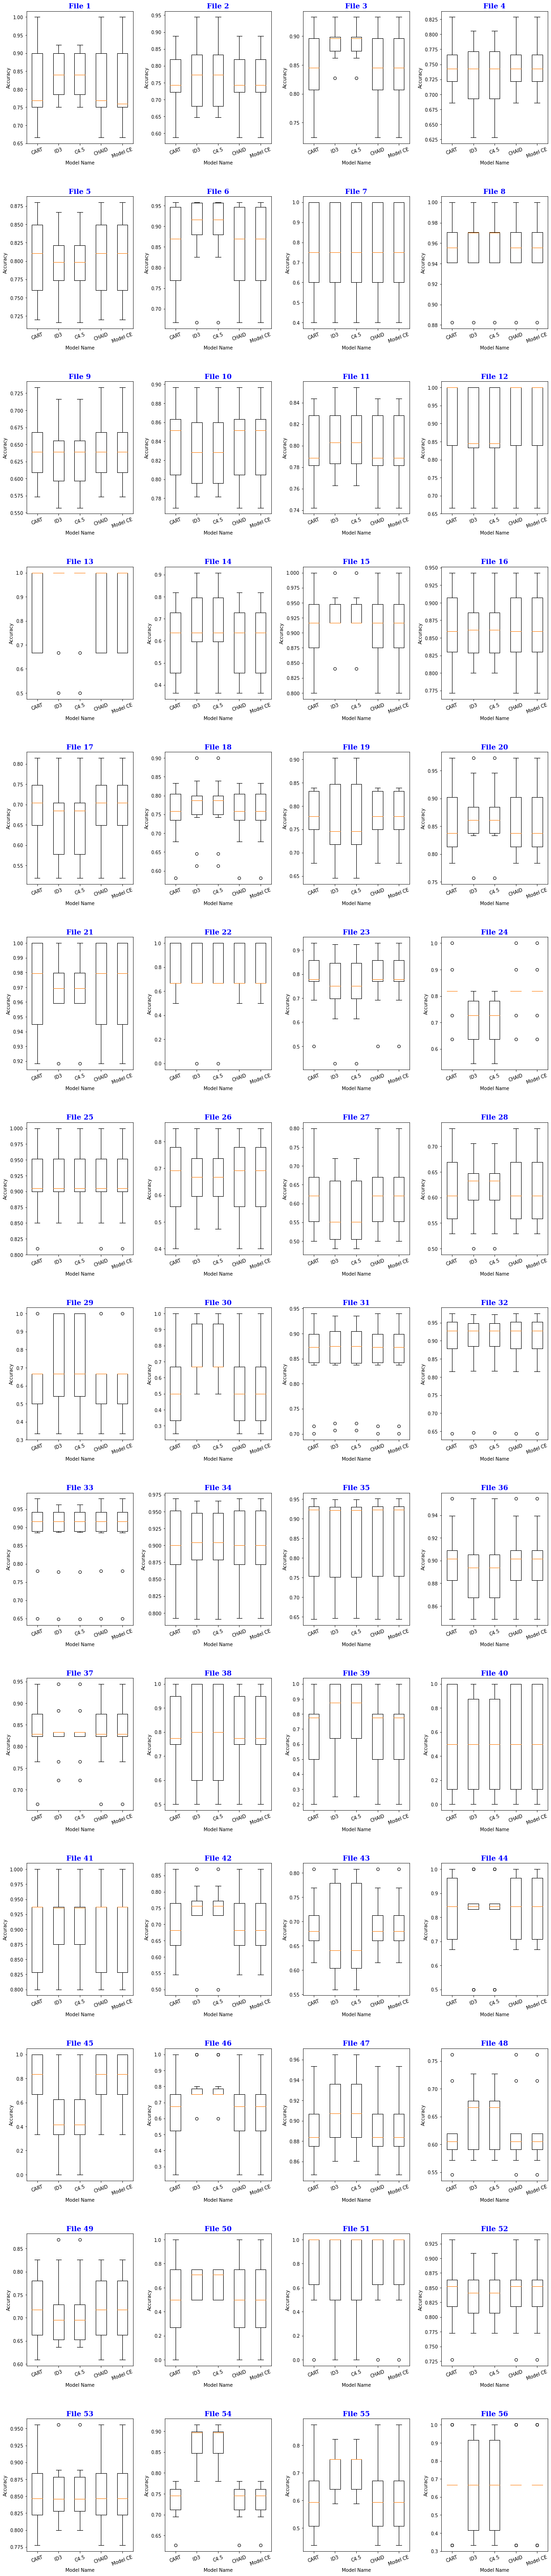

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(20,100))
for i in range(56):
    x=[]
    x.append(a[i])
    x.append(a1[i])
    x.append(a2[i])
    x.append(a3[i])
    x.append(a4[i])
    x=np.array(x)
    df=pd.DataFrame(x.T)
    plt.subplot(14,4, i+1)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    labels=['CART','ID3','C4.5','CHAID','Model CE']
    plt.boxplot(df)
    plt.xticks([1,2,3,4,5],labels,rotation = 20)
    font1 = {'family':'serif','color':'blue','size':15}
    fn='File '+str(i+1)
    plt.title(fn, fontdict = font1,fontweight='bold')
    plt.ylabel("Accuracy")
    plt.xlabel("Model Name")
plt.show()

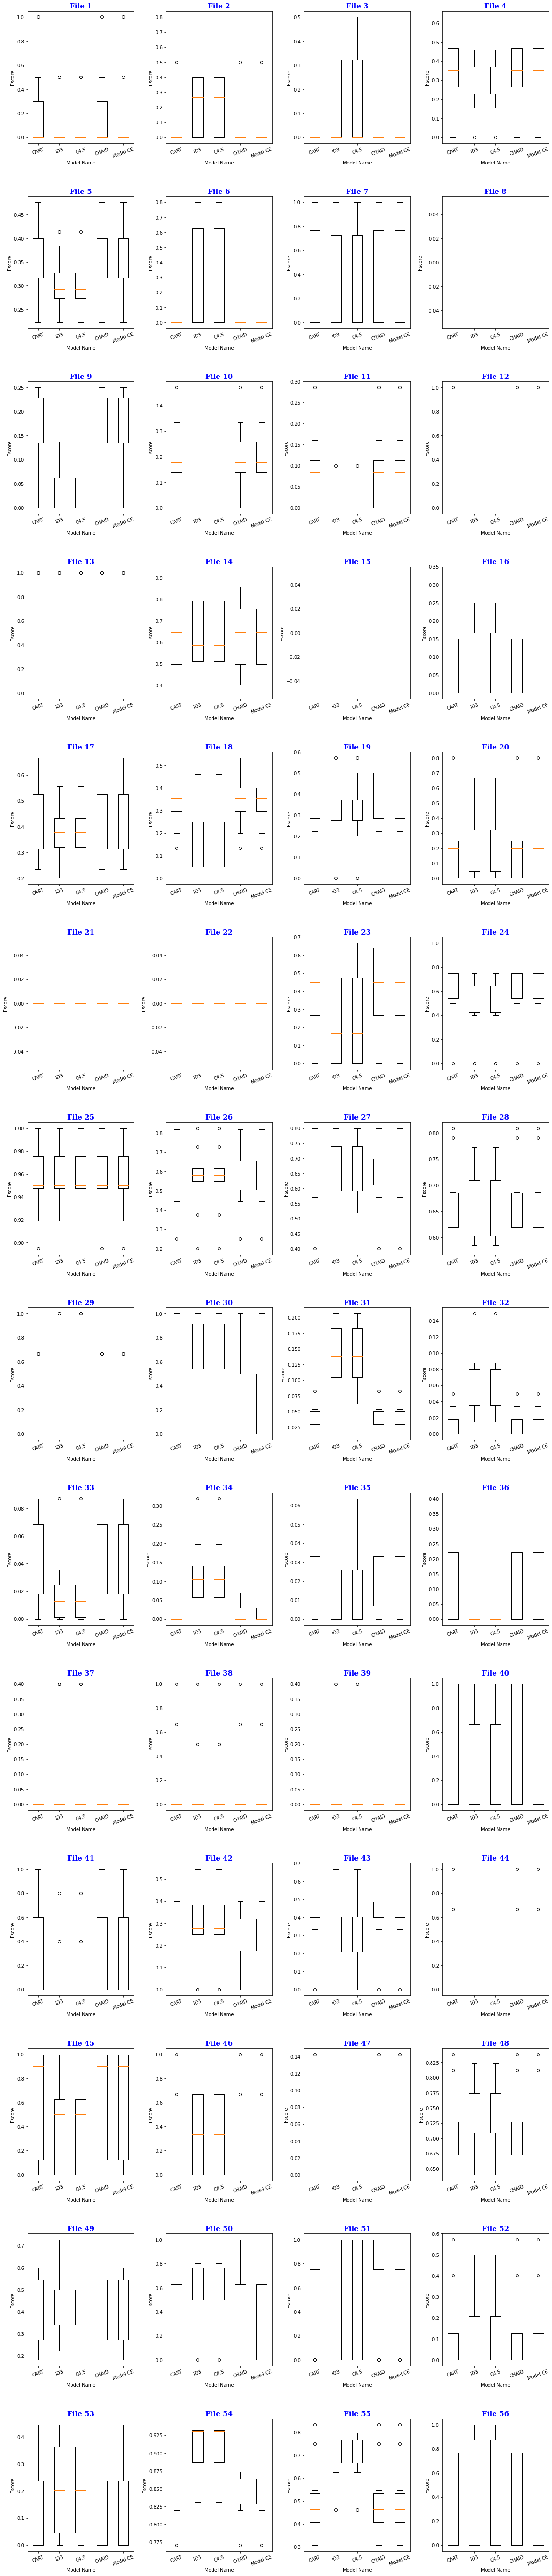

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(20,100))
for i in range(56):
    x=[]
    x.append(f[i])
    x.append(f1[i])
    x.append(f2[i])
    x.append(f3[i])
    x.append(f4[i])
    x=np.array(x)
    df=pd.DataFrame(x.T)
    plt.subplot(14,4, i+1)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    labels=['CART','ID3','C4.5','CHAID','Model CE']
    plt.boxplot(df)
    plt.xticks([1,2,3,4,5],labels,rotation = 20)
    font1 = {'family':'serif','color':'blue','size':15}
    fn='File '+str(i+1)
    plt.title(fn, fontdict = font1,fontweight='bold')
    plt.ylabel("Fscore")
    plt.xlabel("Model Name")
plt.show()

## Printing accuracies and fscores

### CART 

###### Accuracy

In [44]:
df=pd.DataFrame(a)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a[i]))
df['Average']=av

df




,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.769231,0.846154,0.769231,0.923077,1.000000,0.750000,0.750000,0.750000,0.916667,0.666667,0.814103
file 2,0.777778,0.888889,0.833333,0.722222,0.611111,0.833333,0.722222,0.722222,0.588235,0.764706,0.746405
file 3,0.900000,0.933333,0.800000,0.758621,0.862069,0.724138,0.827586,0.896552,0.827586,0.896552,0.842644
file 4,0.750000,0.800000,0.742857,0.828571,0.714286,0.771429,0.742857,0.742857,0.685714,0.714286,0.749286
file 5,0.853333,0.853333,0.720000,0.880000,0.746667,0.810811,0.770270,0.837838,0.810811,0.756757,0.803982
file 6,0.750000,0.958333,0.916667,0.666667,0.956522,0.826087,0.869565,0.739130,0.956522,0.869565,0.850906
file 7,0.600000,0.400000,0.600000,1.000000,1.000000,0.500000,0.750000,1.000000,1.000000,0.750000,0.760000
file 8,0.941176,0.970588,0.882353,0.941176,0.941176,1.000000,0.941176,1.000000,0.970588,0.969697,0.955793
file 9,0.606557,0.655738,0.704918,0.672131,0.622951,0.573770,0.655738,0.590164,0.616667,0.733333,0.643197
file 10,0.863636,0.852273,0.896552,0.781609,0.873563,0.862069,0.850575,0.770115,0.804598,0.804598,0.835959


###### F Measure

In [45]:
df=pd.DataFrame(f)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f[i]))
df['Average']=av
df

,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.400000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190000
file 2,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
file 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 4,0.400000,0.631579,0.000000,0.250000,0.166667,0.500000,0.307692,0.307692,0.476190,0.444444,0.348427
file 5,0.476190,0.266667,0.222222,0.400000,0.387097,0.363636,0.370370,0.454545,0.300000,0.400000,0.364073
file 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 7,0.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.857143,0.000000,1.000000,0.000000,0.385714
file 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 9,0.250000,0.160000,0.250000,0.230769,0.000000,0.133333,0.222222,0.137931,0.000000,0.200000,0.158426
file 10,0.250000,0.133333,0.470588,0.000000,0.153846,0.333333,0.000000,0.166667,0.260870,0.190476,0.195911


### ID3

###### Accuracy

In [46]:
df=pd.DataFrame(a1)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a1[i]))
df['Average']=av

df


,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.769231,0.846154,0.769231,0.923077,0.846154,0.833333,0.916667,0.750000,0.916667,0.833333,0.840385
file 2,0.944444,0.944444,0.722222,0.666667,0.722222,0.833333,0.666667,0.833333,0.647059,0.823529,0.780392
file 3,0.900000,0.933333,0.866667,0.896552,0.931034,0.827586,0.896552,0.896552,0.862069,0.896552,0.890690
file 4,0.805556,0.714286,0.742857,0.771429,0.685714,0.685714,0.771429,0.771429,0.628571,0.742857,0.731984
file 5,0.840000,0.813333,0.760000,0.866667,0.786667,0.810811,0.770270,0.783784,0.824324,0.716216,0.797207
file 6,0.916667,0.916667,0.958333,0.666667,0.956522,0.826087,0.913043,0.869565,0.956522,0.956522,0.893659
file 7,0.600000,0.600000,0.400000,0.500000,1.000000,1.000000,0.750000,1.000000,0.750000,1.000000,0.760000
file 8,0.941176,0.970588,0.882353,0.941176,0.970588,1.000000,0.941176,1.000000,0.970588,0.969697,0.958734
file 9,0.573770,0.655738,0.639344,0.688525,0.655738,0.590164,0.639344,0.557377,0.616667,0.716667,0.633333
file 10,0.829545,0.852273,0.862069,0.804598,0.896552,0.827586,0.862069,0.793103,0.781609,0.793103,0.830251


###### F Measure

In [47]:
df=pd.DataFrame(f1)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f1[i]))
df['Average']=av

df


,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.100000
file 2,0.800000,0.666667,0.000000,0.000000,0.285714,0.000000,0.400000,0.000000,0.250000,0.400000,0.280238
file 3,0.000000,0.000000,0.333333,0.000000,0.500000,0.285714,0.000000,0.400000,0.000000,0.000000,0.151905
file 4,0.461538,0.375000,0.000000,0.200000,0.153846,0.352941,0.333333,0.333333,0.315789,0.400000,0.292578
file 5,0.333333,0.300000,0.307692,0.285714,0.384615,0.222222,0.413793,0.272727,0.235294,0.275862,0.303125
file 6,0.750000,0.000000,0.666667,0.200000,0.000000,0.000000,0.500000,0.400000,0.000000,0.800000,0.331667
file 7,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,0.857143,0.000000,0.800000,0.000000,0.365714
file 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 9,0.000000,0.086957,0.083333,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.030822
file 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### C4.5

###### Accuracy

In [48]:
df=pd.DataFrame(a2)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a2[i]))
df['Average']=av


df


,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.769231,0.846154,0.769231,0.923077,0.846154,0.833333,0.916667,0.750000,0.916667,0.833333,0.840385
file 2,0.944444,0.944444,0.722222,0.666667,0.722222,0.833333,0.666667,0.833333,0.647059,0.823529,0.780392
file 3,0.900000,0.933333,0.866667,0.896552,0.931034,0.827586,0.896552,0.896552,0.862069,0.896552,0.890690
file 4,0.805556,0.714286,0.742857,0.771429,0.685714,0.685714,0.771429,0.771429,0.628571,0.742857,0.731984
file 5,0.840000,0.813333,0.760000,0.866667,0.786667,0.810811,0.770270,0.783784,0.824324,0.716216,0.797207
file 6,0.916667,0.916667,0.958333,0.666667,0.956522,0.826087,0.913043,0.869565,0.956522,0.956522,0.893659
file 7,0.600000,0.600000,0.400000,0.500000,1.000000,1.000000,0.750000,1.000000,0.750000,1.000000,0.760000
file 8,0.941176,0.970588,0.882353,0.941176,0.970588,1.000000,0.941176,1.000000,0.970588,0.969697,0.958734
file 9,0.573770,0.655738,0.639344,0.688525,0.655738,0.590164,0.639344,0.557377,0.616667,0.716667,0.633333
file 10,0.829545,0.852273,0.862069,0.804598,0.896552,0.827586,0.862069,0.793103,0.781609,0.793103,0.830251


###### F Measure

In [49]:
df=pd.DataFrame(f2)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f2[i]))
df['Average']=av

df

,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.100000
file 2,0.800000,0.666667,0.000000,0.000000,0.285714,0.000000,0.400000,0.000000,0.250000,0.400000,0.280238
file 3,0.000000,0.000000,0.333333,0.000000,0.500000,0.285714,0.000000,0.400000,0.000000,0.000000,0.151905
file 4,0.461538,0.375000,0.000000,0.200000,0.153846,0.352941,0.333333,0.333333,0.315789,0.400000,0.292578
file 5,0.333333,0.300000,0.307692,0.285714,0.384615,0.222222,0.413793,0.272727,0.235294,0.275862,0.303125
file 6,0.750000,0.000000,0.666667,0.200000,0.000000,0.000000,0.500000,0.400000,0.000000,0.800000,0.331667
file 7,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,0.857143,0.000000,0.800000,0.000000,0.365714
file 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 9,0.000000,0.086957,0.083333,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.030822
file 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### CHAID

###### Accuracy

In [50]:
df=pd.DataFrame(a3)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a3[i]))
df['Average']=av

df

,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.769231,0.846154,0.769231,0.923077,1.000000,0.750000,0.750000,0.750000,0.916667,0.666667,0.814103
file 2,0.777778,0.888889,0.833333,0.722222,0.611111,0.833333,0.722222,0.722222,0.588235,0.764706,0.746405
file 3,0.900000,0.933333,0.800000,0.758621,0.862069,0.724138,0.827586,0.896552,0.827586,0.896552,0.842644
file 4,0.750000,0.800000,0.742857,0.828571,0.714286,0.771429,0.742857,0.742857,0.685714,0.714286,0.749286
file 5,0.853333,0.853333,0.720000,0.880000,0.746667,0.810811,0.770270,0.837838,0.810811,0.756757,0.803982
file 6,0.750000,0.958333,0.916667,0.666667,0.956522,0.826087,0.869565,0.739130,0.956522,0.869565,0.850906
file 7,0.600000,0.400000,0.600000,1.000000,1.000000,0.500000,0.750000,1.000000,1.000000,0.750000,0.760000
file 8,0.941176,0.970588,0.882353,0.941176,0.941176,1.000000,0.941176,1.000000,0.970588,0.969697,0.955793
file 9,0.606557,0.655738,0.704918,0.672131,0.622951,0.573770,0.655738,0.590164,0.616667,0.733333,0.643197
file 10,0.863636,0.852273,0.896552,0.781609,0.873563,0.862069,0.850575,0.770115,0.804598,0.804598,0.835959


###### F Measure

In [51]:
df=pd.DataFrame(f3)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f3[i]))
df['Average']=av

df


,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.400000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190000
file 2,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
file 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 4,0.400000,0.631579,0.000000,0.250000,0.166667,0.500000,0.307692,0.307692,0.476190,0.444444,0.348427
file 5,0.476190,0.266667,0.222222,0.400000,0.387097,0.363636,0.370370,0.454545,0.300000,0.400000,0.364073
file 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 7,0.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.857143,0.000000,1.000000,0.000000,0.385714
file 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 9,0.250000,0.160000,0.250000,0.230769,0.000000,0.133333,0.222222,0.137931,0.000000,0.200000,0.158426
file 10,0.250000,0.133333,0.470588,0.000000,0.153846,0.333333,0.000000,0.166667,0.260870,0.190476,0.195911


### Model using Classification error

###### Accuracy

In [52]:
df=pd.DataFrame(a4)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(a4[i]))
df['Average']=av

df

,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.692308,0.846154,0.769231,0.923077,1.000000,0.750000,0.750000,0.750000,0.916667,0.666667,0.806410
file 2,0.777778,0.888889,0.833333,0.722222,0.611111,0.833333,0.722222,0.722222,0.588235,0.764706,0.746405
file 3,0.900000,0.933333,0.800000,0.758621,0.862069,0.724138,0.827586,0.896552,0.827586,0.896552,0.842644
file 4,0.750000,0.800000,0.742857,0.828571,0.714286,0.771429,0.742857,0.742857,0.685714,0.714286,0.749286
file 5,0.853333,0.853333,0.720000,0.880000,0.746667,0.810811,0.770270,0.837838,0.810811,0.756757,0.803982
file 6,0.750000,0.958333,0.916667,0.666667,0.956522,0.826087,0.869565,0.739130,0.956522,0.869565,0.850906
file 7,0.600000,0.400000,0.600000,1.000000,1.000000,0.500000,0.750000,1.000000,1.000000,0.750000,0.760000
file 8,0.941176,0.970588,0.882353,0.941176,0.941176,1.000000,0.941176,1.000000,0.970588,0.969697,0.955793
file 9,0.606557,0.655738,0.704918,0.672131,0.622951,0.573770,0.655738,0.590164,0.616667,0.733333,0.643197
file 10,0.863636,0.852273,0.896552,0.781609,0.873563,0.862069,0.850575,0.770115,0.804598,0.804598,0.835959


###### F Measure

In [53]:

df=pd.DataFrame(f4)
df.columns=dfcol
df.index=dfrow
av=[]
for i in range(56):
    av.append(np.mean(f4[i]))
df['Average']=av
df

,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,Average
file 1,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000
file 2,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
file 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 4,0.400000,0.631579,0.000000,0.250000,0.166667,0.500000,0.307692,0.307692,0.476190,0.444444,0.348427
file 5,0.476190,0.266667,0.222222,0.400000,0.387097,0.363636,0.370370,0.454545,0.300000,0.400000,0.364073
file 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 7,0.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.857143,0.000000,1.000000,0.000000,0.385714
file 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
file 9,0.250000,0.160000,0.250000,0.230769,0.000000,0.133333,0.222222,0.137931,0.000000,0.200000,0.158426
file 10,0.250000,0.133333,0.470588,0.000000,0.153846,0.333333,0.000000,0.166667,0.260870,0.190476,0.195911
